In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

In [3]:
# Load CSV
print("Loading dataset...")
df = pd.read_csv("./yelp_reviews.csv")
df = df[df['stars'] != 3]  # Remove neutral reviews
df['label'] = (df['stars'] >= 4).astype(int)
df.drop(columns='stars', inplace=True)

Loading dataset...


In [4]:
# Shuffle and split
print("Splitting dataset...")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
n_total = int(0.0158774*len(df))
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train + n_val]
df_test = df.iloc[n_train + n_val:n_train + 2*n_val]

Splitting dataset...


In [5]:
# Tokenization and preprocessing
tokenizer = RegexpTokenizer(r'\w+')
porter_stemmer = PorterStemmer()
def preprocess(text, stemming=False, lowercase=False):
    if not isinstance(text, str):
        text = ""
    if lowercase:
        text = text.lower()
    tokens = tokenizer.tokenize(text)
    if stemming:
        tokens = [porter_stemmer.stem(w) for w in tokens if w not in {'aed','oed','eed'}]
    return tokens

print("Tokenizing reviews...")
stemming = False
lowercase = False

tqdm.pandas()

df_train['tokens'] = df_train['text'].progress_apply(lambda x: preprocess(x, stemming, lowercase))
df_val['tokens']   = df_val['text'].progress_apply(lambda x: preprocess(x, stemming, lowercase))
df_test['tokens']  = df_test['text'].progress_apply(lambda x: preprocess(x, stemming, lowercase))


Tokenizing reviews...


100%|██████████| 80000/80000 [00:01<00:00, 46248.17it/s]
C:\Users\OMGEp\AppData\Local\Temp\ipykernel_9960\3305393269.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tokens'] = df_train['text'].progress_apply(lambda x: preprocess(x, stemming, lowercase))
100%|██████████| 10000/10000 [00:00<00:00, 51670.73it/s]
C:\Users\OMGEp\AppData\Local\Temp\ipykernel_9960\3305393269.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['tokens']   = df_val['text'].progress_apply(lambda x: preprocess(x

In [6]:
# Extract sets
train_set, train_labels = df_train['tokens'].tolist(), df_train['label'].tolist()
dev_set, dev_labels = df_val['tokens'].tolist(), df_val['label'].tolist()
test_set, test_labels = df_test['tokens'].tolist(), df_test['label'].tolist()

In [7]:
from collections import defaultdict
import math

# Bigram Naive Bayes Classifier
def bigram_bayes(train_set, train_labels, dev_set,
                 unigram_laplace=0.6, bigram_laplace=0.8,
                 bigram_lambda=0.7, pos_prior=0.5):

    pos_unigram = defaultdict(int)
    neg_unigram = defaultdict(int)
    pos_bigram = defaultdict(int)
    neg_bigram = defaultdict(int)

    # Count unigrams and bigrams in positive and negative training examples based on label
    for tokens, label in zip(train_set, train_labels):
        for i in range(len(tokens)):
            if label == 1:
                pos_unigram[tokens[i]] += 1
            else:
                neg_unigram[tokens[i]] += 1
            if i < len(tokens) - 1:
                bigram = (tokens[i], tokens[i+1])
                if label == 1:
                    pos_bigram[bigram] += 1
                else:
                    neg_bigram[bigram] += 1

    # Compute vocabularies and total unigram/bigram counts for each class
    V_uni = set(pos_unigram) | set(neg_unigram)
    V_bi  = set(pos_bigram) | set(neg_bigram)
    N_pos_uni = sum(pos_unigram.values())
    N_neg_uni = sum(neg_unigram.values())
    N_pos_bi  = sum(pos_bigram.values())
    N_neg_bi  = sum(neg_bigram.values())

    predictions = []
    # Compute smoothed log-probs for positive and negative classes using bigram/unigram
    # Predict class with higher combined score
    for tokens in dev_set:
        pos_uni_logprob = np.log(pos_prior)
        neg_uni_logprob = np.log(1 - pos_prior)
        pos_bi_logprob  = np.log(pos_prior)
        neg_bi_logprob  = np.log(1 - pos_prior)

        for word in tokens:
            pos_uni_logprob += np.log((pos_unigram[word] + unigram_laplace) / (N_pos_uni + unigram_laplace * len(V_uni)))
            neg_uni_logprob += np.log((neg_unigram[word] + unigram_laplace) / (N_neg_uni + unigram_laplace * len(V_uni)))

        for i in range(len(tokens) - 1):
            bigram = (tokens[i], tokens[i+1])
            pos_bi_logprob += np.log((pos_bigram[bigram] + bigram_laplace) / (N_pos_bi + bigram_laplace * len(V_bi)))
            neg_bi_logprob += np.log((neg_bigram[bigram] + bigram_laplace) / (N_neg_bi + bigram_laplace * len(V_bi)))

        pos_logprob = (1 - bigram_lambda) * pos_uni_logprob + bigram_lambda * pos_bi_logprob
        neg_logprob = (1 - bigram_lambda) * neg_uni_logprob + bigram_lambda * neg_bi_logprob

        predictions.append(1 if pos_logprob > neg_logprob else 0)
    return predictions, pos_unigram, neg_unigram, pos_bigram, neg_bigram


Training and evaluating bigram Naive Bayes on validation set...

Accuracy: 0.9252


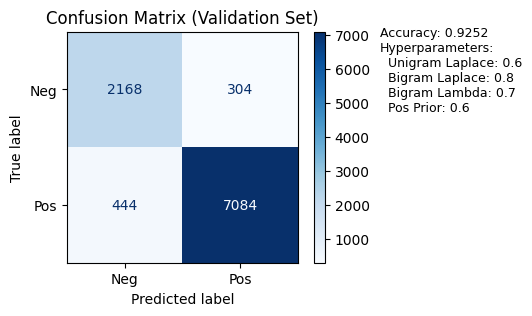

Training and evaluating bigram Naive Bayes on test set...

Accuracy: 0.9271


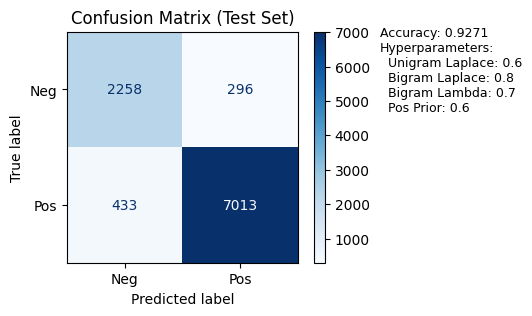

In [17]:
print("Training and evaluating bigram Naive Bayes on validation set...")
predicted, pos_unigram, neg_unigram, pos_bigram, neg_bigram = bigram_bayes(train_set, train_labels, dev_set, unigram_laplace=0.6, bigram_laplace=0.8, bigram_lambda=0.7, pos_prior=0.6)

accuracy_dev = accuracy_score(dev_labels, predicted)
print("\nAccuracy:", accuracy_dev)
disp = ConfusionMatrixDisplay.from_predictions(dev_labels, predicted, display_labels=['Neg', 'Pos'], cmap='Blues')
disp.figure_.set_size_inches(4, 3)
plt.title("Confusion Matrix (Validation Set)")
textstr = '\n'.join([
    f'Accuracy: {accuracy_dev:.4f}',
    'Hyperparameters:',
    f'  Unigram Laplace: 0.6',
    f'  Bigram Laplace: 0.8',
    f'  Bigram Lambda: 0.7',
    f'  Pos Prior: 0.6'
])
plt.gcf().text(0.95, 0.75, textstr, fontsize=9, va='center')
plt.show()

print("Training and evaluating bigram Naive Bayes on test set...")
predicted, pos_unigram, neg_unigram, pos_bigram, neg_bigram = bigram_bayes(train_set, train_labels, test_set, unigram_laplace=0.6, bigram_laplace=0.8, bigram_lambda=0.7, pos_prior=0.6)

accuracy_test = accuracy_score(test_labels, predicted)
print("\nAccuracy:", accuracy_test)
disp = ConfusionMatrixDisplay.from_predictions(test_labels, predicted, display_labels=['Neg', 'Pos'], cmap='Blues')
disp.figure_.set_size_inches(4, 3)
plt.title("Confusion Matrix (Test Set)")
textstr = '\n'.join([
    f'Accuracy: {accuracy_test:.4f}',
    'Hyperparameters:',
    f'  Unigram Laplace: 0.6',
    f'  Bigram Laplace: 0.8',
    f'  Bigram Lambda: 0.7',
    f'  Pos Prior: 0.6'
])
plt.gcf().text(0.95, 0.75, textstr, fontsize=9, va='center')
plt.show()

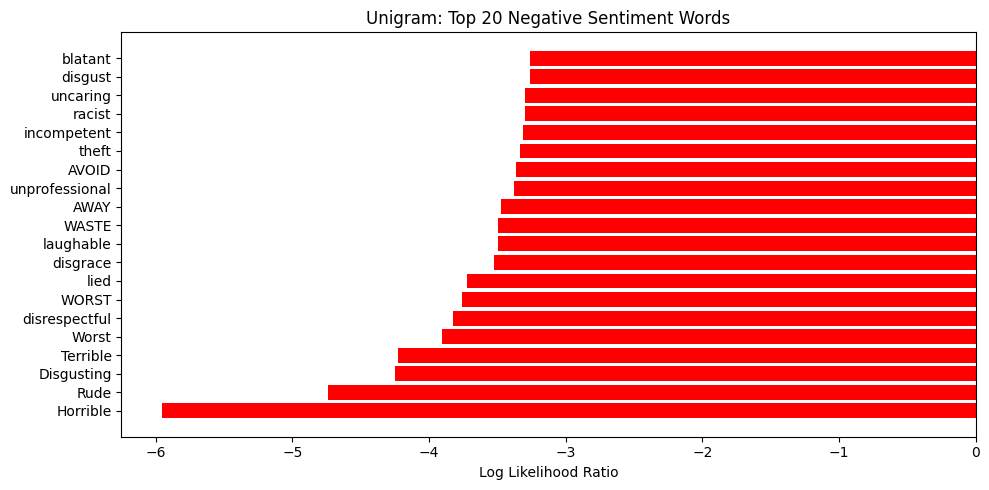

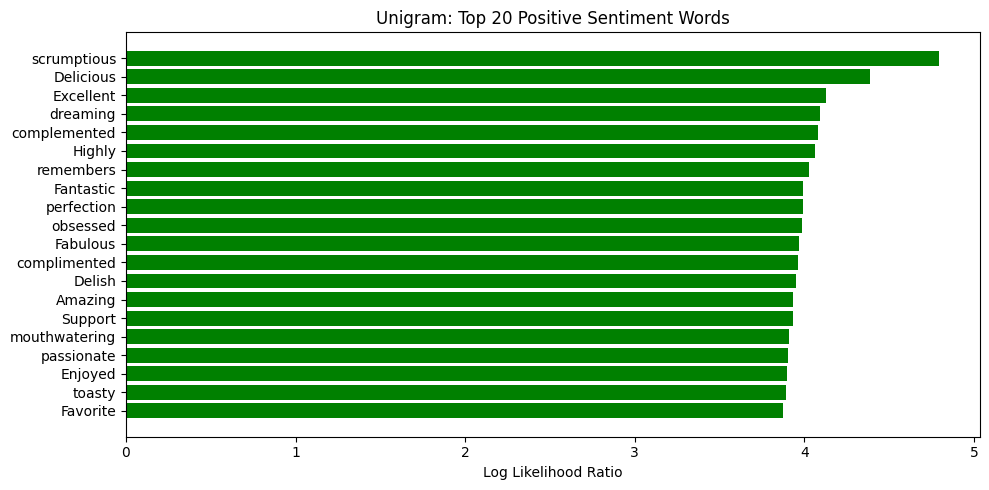

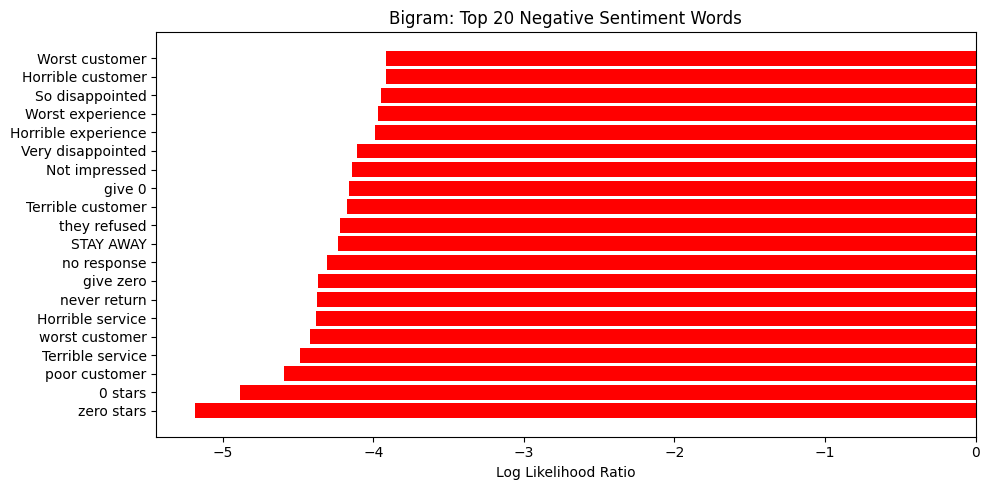

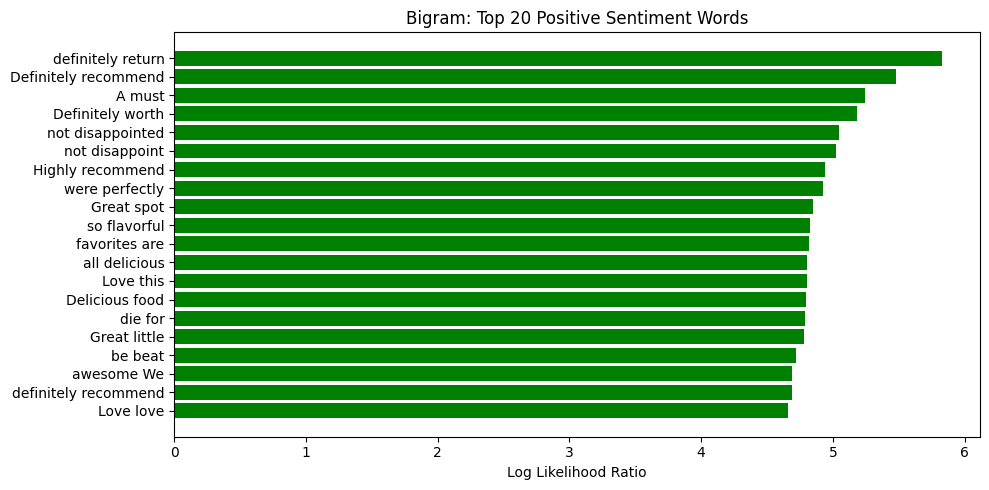

In [9]:
def plot_top_nb_features(pos_counts, neg_counts, top_n=20, title_prefix=""):
    all_words = set(pos_counts) | set(neg_counts)
    word_scores = {}
    
    for word in all_words:
        # Apply Laplace smoothing
        pos = pos_counts[word] + 1
        neg = neg_counts[word] + 1
        score = np.log(pos / neg)
        word_scores[word] = score

    # Separate top positive and negative words
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1])
    top_neg = sorted_words[:top_n]
    top_pos = sorted_words[-top_n:]

    # Convert tuple keys (bigrams) to strings if needed
    def format_word(w):
        return ' '.join(w) if isinstance(w, tuple) else w

    # Plot negative words
    neg_words, neg_scores = zip(*top_neg)
    neg_words = [format_word(w) for w in neg_words]
    plt.figure(figsize=(10, 5))
    plt.barh(neg_words, neg_scores, color='red')
    plt.title(f"{title_prefix}Top {top_n} Negative Sentiment Words")
    plt.xlabel("Log Likelihood Ratio")
    plt.tight_layout()
    plt.show()

    # Plot positive words
    pos_words, pos_scores = zip(*top_pos)
    pos_words = [format_word(w) for w in pos_words]
    plt.figure(figsize=(10, 5))
    plt.barh(pos_words, pos_scores, color='green')
    plt.title(f"{title_prefix}Top {top_n} Positive Sentiment Words")
    plt.xlabel("Log Likelihood Ratio")
    plt.tight_layout()
    plt.show()

# Plot top positive/negative unigrams/bigrams
plot_top_nb_features(pos_unigram, neg_unigram, top_n=20, title_prefix="Unigram: ")
plot_top_nb_features(pos_bigram, neg_bigram, top_n=20, title_prefix="Bigram: ")